In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tqdm
import sys

from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from tqdm import tnrange, tqdm_notebook

In [3]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(2, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        
        self.fc1 = nn.Linear(5184, 128)
        #self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 5)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 3)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 3)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [4]:
def train(model, device, train_loader, optimizer, epoch, batch_size):
    model.train()
    
    tr = tnrange((len(train_loader))*batch_size, file=sys.stdout)
    tr.set_description('Epoch %s' % epoch)
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        tr.update(len(data))
        tr.set_description('Epoch {}\tLoss: {:.6f}'.format(epoch, loss.item()))

In [5]:
def test(model, device, test_loader, batch_size):
    model.eval()
    test_loss = 0
    correct = 0
    
    tr = tnrange((len(test_loader))*batch_size, file=sys.stdout)
    tr.set_description('Test set:')
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            tr.update(len(data))
           
        test_loss /= len(test_loader.dataset)
        
        tr.set_description('Average loss: {:.4f}, Accuracy:{}/{} ({:.0f}%)'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

In [6]:
torch.manual_seed(1)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

parallel_net = nn.DataParallel(Net(), device_ids = [0,1,2])
parallel_net.to(device)

/home/adpol/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/parallel/data_parallel.py:26: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


DataParallel(
  (module): Net(
    (conv1): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (dropout1): Dropout2d(p=0.25, inplace=False)
    (dropout2): Dropout2d(p=0.5, inplace=False)
    (fc1): Linear(in_features=5184, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=5, bias=True)
  )
)

In [7]:
# Get data loader here :)

class ImagesDataset(torch.utils.data.Dataset):
    
    def __init__(self,
                 hdf5_dataset=None,
                 labels_output_format=('class_id', 'xmin', 'ymin', 'xmax', 'ymax', 'pt')):
        
        self.hdf5_dataset = hdf5_dataset
        self.labels_output_format = labels_output_format
        
        self.height = 452 # Height of the input images
        self.width = 340 # Width of the input images
        self.channels = 2 # Number of color channels of the input images
        
        # This dictionary is for internal use
        self.labels_format={'class_id': labels_output_format.index('class_id'),
                            'xmin': labels_output_format.index('xmin'),
                            'ymin': labels_output_format.index('ymin'),
                            'xmax': labels_output_format.index('xmax'),
                            'ymax': labels_output_format.index('ymax'),
                            'pt': labels_output_format.index('pt')}

        self.labels = self.hdf5_dataset['labels']
        self.shapes = self.hdf5_dataset['label_shapes']
        self.calorimeter = self.hdf5_dataset['calorimeter']
        
        self.dataset_size = len(self.calorimeter)
        
    def __getitem__(self, index):

        label_raw = self.labels[index]
        shape_raw = self.shapes[index]
        label_reshaped = label_raw.reshape(shape_raw)
        
        inx = -1
        
        for x, i in enumerate(label_reshaped):
            if i[1] < 248 and i[2] < 360:
                inx = x
                break         
        
        calorimeter = self.calorimeter[index]
        calorimeter = calorimeter.reshape(self.channels, self.height, self.width)
        
        if inx != -1 and len(label_reshaped):
            jet_type = label_reshaped[:, self.labels_format['class_id']][inx]
            
            calorimeter = calorimeter[:,
                                      label_reshaped[inx][self.labels_format['ymin']]:label_reshaped[inx][self.labels_format['ymin']]+92,
                                      label_reshaped[inx][self.labels_format['xmin']]:label_reshaped[inx][self.labels_format['xmin']]+92]
            
        else:
            jet_type = 0
            calorimeter = calorimeter[:,
                                      0:92,
                                      0:92]
        calorimeter_max = calorimeter.reshape(self.channels, -1).max(axis=1).reshape(self.channels, 1, 1)+0.00001
        calorimeter = calorimeter / calorimeter_max
            
        # Channels last
        #calorimeter = np.rollaxis(calorimeter, 0, 3)

        return torch.from_numpy(np.asarray(calorimeter, dtype=np.float32)), torch.from_numpy(np.asarray(jet_type, dtype=np.int64))
    def __len__(self):
        return self.dataset_size

In [8]:
DATA_SOURCE = '/eos/user/a/adpol/ceva/fast'

batch_size = 50
train_dataset_path = '%s/RSGraviton_NARROW_0.h5' % DATA_SOURCE
h5_train = h5py.File(train_dataset_path, 'r')

# initialize our dataset at first
train_dataset = ImagesDataset(hdf5_dataset=h5_train)

# initialize data loader with required number of workers and other params
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=1)

test_dataset_path = '%s/RSGraviton_NARROW_1.h5' % DATA_SOURCE
h5_test = h5py.File(test_dataset_path, 'r')

# initialize our dataset at first
test_dataset = ImagesDataset(hdf5_dataset=h5_test)

# initialize data loader with required number of workers and other params
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=1)

In [9]:
optimizer = optim.Adam(parallel_net.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=1, gamma=.7)

for epoch in range(20):
    train(parallel_net, device, train_loader, optimizer, epoch+1, batch_size)
    test(parallel_net, device, test_loader, batch_size)
    scheduler.step()

In [11]:
from sklearn.metrics import confusion_matrix

nb_classes = 9

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = parallel_net(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

[[ 121    8    0    3    1]
 [  12 2483    0    3    0]
 [   0    0 1485  598  415]
 [   9    1  933 1049  483]
 [   2    1  381  347 1665]]
[90.97744361 99.39951962 59.44755805 42.38383838 69.49081803]


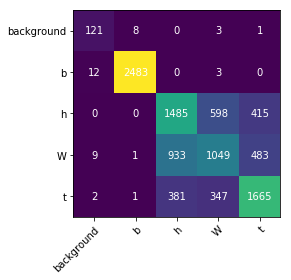

In [27]:
fig, ax = plt.subplots()
im = ax.imshow(conf_mat)

# We want to show all ticks...
ax.set_xticks(np.arange(len(CLASSES)))
ax.set_yticks(np.arange(len(CLASSES)))
ax.set_xticklabels(CLASSES)
ax.set_yticklabels(CLASSES)

# CLASSES = ['background', 'b', 'h', 'W', 't']
# plt.matshow(conf_mat, cmap='Greys')
# plt.yticks(range(5), CLASSES, va='center')
# plt.xticks(range(5), CLASSES, va='center')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(CLASSES)):
    for j in range(len(CLASSES)):
        text = ax.text(j, i, conf_mat[i, j],
                       ha="center", va="center", color="w")

fig.tight_layout()
plt.show()

In [14]:
h5_train.close()
h5_test.close()

NameError: name 'h5_train' is not defined